<h3>This notebook contains code used to create bounding boxes around crack segmentation masks.</h3>

There's also a need to perform some data engineering. Some segmentation masks are not very accurate. Some contain disconnected clusters of pixels that in reality should be one segmentation mask, while others contains some weird looking artifacts around those segmentation masks that are otherwise valid. To combat both of those problems certain strategies have or could have been employed:
1. Consider only bounding boxes for areas greater than 20
2. Merge bounding boxes if they are very close to each other
3. Interpolate between closely laid out points

Step #3 was not executed. However, if the dataset could have been split into multiple ones, it would be possible to execute it only on those subdatasets that exhibit this problem. Because of simplicity it was easier to just exclude some of the images.

In [1]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

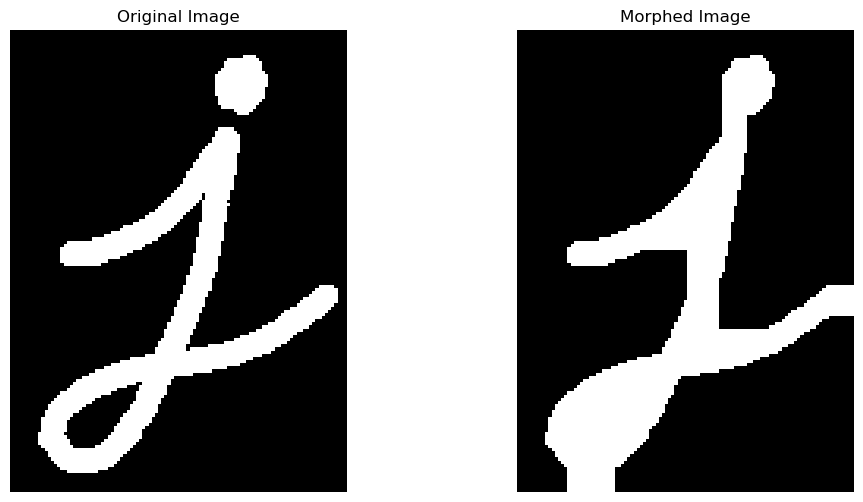

In [6]:
test_img = cv2.imread(os.path.join("data", "tests", "i.png"), cv2.IMREAD_GRAYSCALE)
test_kernel = np.ones((15, 15), np.uint8)
morphed_test_img = cv2.morphologyEx(test_img, cv2.MORPH_CLOSE, test_kernel)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(morphed_test_img, cmap="gray")
plt.title("Morphed Image")
plt.axis("off")

plt.show()

In [2]:
train_dir = os.path.join("data", "train")
valid_dir = os.path.join("data", "valid")
images_dir_train = os.path.join(train_dir, "images")
images_dir_valid = os.path.join(valid_dir, "images")
masks_dir_train = os.path.join(train_dir, "masks")
masks_dir_valid = os.path.join(valid_dir, "masks")

In [3]:
def get_coco_tpl() -> dict:
    return {
        "images": [],
        "annotations": [],
        "categories": [{
            "id": 1,
            "name": "crack",
            "supercategory": "defect"
        }]
    }

In [4]:
def merge_adjacent_bboxes(bboxes: list[list[int]], threshold: int = 10) -> list[list[int]]:
    merged_bboxes = []

    while bboxes:
        current_bbox = bboxes.pop(0)
        merged = True

        while merged:
            merged = False
            
            for i, bbox in enumerate(bboxes):
                if (current_bbox[0] - threshold < bbox[0] + bbox[2] and
                    current_bbox[0] + current_bbox[2] + threshold > bbox[0] and
                    current_bbox[1] - threshold < bbox[1] + bbox[3] and
                    current_bbox[1] + current_bbox[3] + threshold > bbox[1]):

                    x_min = min(current_bbox[0], bbox[0])
                    y_min = min(current_bbox[1], bbox[1])
                    x_max = max(current_bbox[0] + current_bbox[2], bbox[0] + bbox[2])
                    y_max = max(current_bbox[1] + current_bbox[3], bbox[1] + bbox[3])
                    current_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
                    bboxes.pop(i)
                    merged = True
                    break

        merged_bboxes.append(current_bbox)

    return merged_bboxes

In [5]:
def find_boxes(images_dir: str, masks_dir: str, coco_format: dict, closing_kernel_size: int = 15) -> None:
    annotation_id = 1
    image_id_mapping = {}
    kernel = np.ones((closing_kernel_size, closing_kernel_size), np.uint8)

    for mask_filename in os.listdir(masks_dir):
        image_id = os.path.splitext(mask_filename)[0]

        if "cracktree" in image_id.lower():
            continue
        
        mask_path = os.path.join(masks_dir, mask_filename)
        image_path = os.path.join(images_dir, f"{image_id}.jpg")

        if not os.path.exists(image_path):
            continue

        image_id_mapping[image_id] = len(image_id_mapping) + 1
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None or np.sum(mask) == 0:
            annotation_entry = {
                "id": annotation_id,
                "image_id": image_id_mapping[image_id],
                "category_id": 1,
                "bbox": [],
                "area": 0,
                "segmentation": [],
                "iscrowd": 0,
                "label": f"no crack {annotation_id}"
            }
            coco_format["annotations"].append(annotation_entry)
            annotation_id += 1

        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        _, binary_image = cv2.threshold(closed_mask, 127, 255, cv2.THRESH_BINARY)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

        if image_id not in coco_format["images"]:
            image_entry = {
                "id": image_id_mapping[image_id],
                "file_name": os.path.basename(image_path),
                "width": mask.shape[1],
                "height": mask.shape[0],
                "license": 1,
                "flickr_url": "",
                "coco_url": "",
                "date_captured": ""
            }
            coco_format["images"].append(image_entry)

        bboxes = []
        segmentations = []

        for j in range(1, num_labels):
            if stats[j, cv2.CC_STAT_AREA] > 20:
                bbox = [
                    int(stats[j, cv2.CC_STAT_LEFT]),
                    int(stats[j, cv2.CC_STAT_TOP]),
                    int(stats[j, cv2.CC_STAT_WIDTH]),
                    int(stats[j, cv2.CC_STAT_HEIGHT])
                ]
                mask_region = (labels == j).astype(np.uint8)
                contours, _ = cv2.findContours(mask_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                segmentation = [contour.flatten().tolist() for contour in contours if contour.size >= 6]

                bboxes.append(bbox)
                segmentations.append(segmentation)

        merged_bboxes = merge_adjacent_bboxes(bboxes)

        for bbox, segmentation in zip(merged_bboxes, segmentations):
            annotation_entry = {
                "id": annotation_id,
                "image_id": image_id_mapping[image_id],
                "category_id": 1,
                "bbox": bbox,
                "area": bbox[2] * bbox[3],
                "segmentation": segmentation,
                "iscrowd": 0,
                "label": f"crack {annotation_id}"
            }
            coco_format["annotations"].append(annotation_entry)
            annotation_id += 1

    print(f"Entries count: {len(coco_format['annotations'])}")

In [6]:
def build_coco(images_dir: str, masks_dir: str, prefix: str) -> None:
    coco_format = get_coco_tpl()
    find_boxes(images_dir, masks_dir, coco_format)
    output_file = os.path.join("data", prefix, f"coco_annotations.json")

    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, "w") as f:
        json.dump(coco_format, f, indent=4)

    print(f"COCO format annotations saved to {output_file}")

In [7]:
build_coco(images_dir_train, masks_dir_train, "train")

Entries count: 12582
COCO format annotations saved to data\train\coco_annotations.json


In [8]:
build_coco(images_dir_valid, masks_dir_valid, "valid")

Entries count: 2197
COCO format annotations saved to data\valid\coco_annotations.json
